In [533]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import holidays
import itertools

from pandas import CategoricalDtype
from bs4 import BeautifulSoup
from datetime import date
from prophet import Prophet
from prophet.serialize import model_to_json
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid, GridSearchCV
from scipy import stats
from tqdm import tqdm

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics



# Parcing data

In [534]:
# парсинг ключевой ставки в df
URL = 'https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=' + date.today().strftime('%d.%m.%Y')

data = requests.get(URL).text

bs4 = BeautifulSoup(data, "html.parser")
table = bs4.find_all("table")

df = pd.read_html(str(table))[0]
df.iloc[:,1:] /= 100

In [535]:
# преобразование столбца дата в формат datetime
df['Дата'] = pd.to_datetime(df['Дата'], dayfirst=True)

# перенаименование столбцов
df.columns = ['date', 'key_rate']

In [536]:
# общая информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2645 entries, 0 to 2644
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2645 non-null   datetime64[ns]
 1   key_rate  2645 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 41.5 KB


In [537]:
# основные описательные статистики для числовых признаков
df.iloc[:, 1:].describe()

,key_rate
count,2645.000000
mean,8.735633
std,3.199225
min,4.250000
25%,7.000000
50%,7.750000
75%,10.500000
max,20.000000


In [538]:
df[:5]

,date,key_rate
0,2024-04-18,16.0
1,2024-04-17,16.0
2,2024-04-16,16.0
3,2024-04-15,16.0
4,2024-04-12,16.0


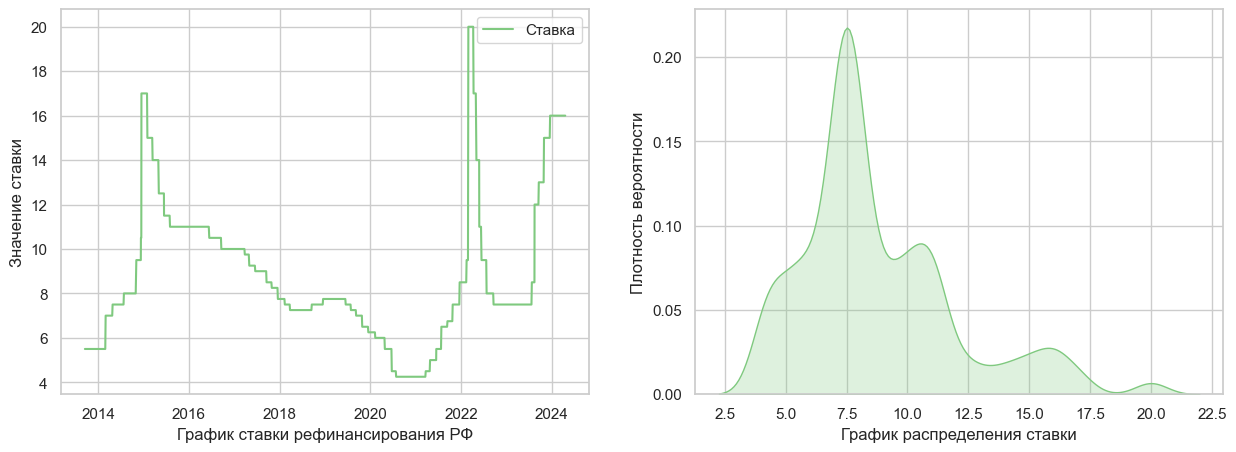

In [539]:
# рисуем график курса ключевой ствки ЦБ РФ и график распределения
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.set_theme(style="whitegrid", palette="Accent")

sns.lineplot(x='date', y='key_rate', data=df, label='Ставка', ax=axes[0])
axes[0].set_xlabel('График ставки рефинансирования РФ')
axes[0].set_ylabel('Значение ставки')
axes[0].legend(loc='best')
axes[0].grid(True)

sns.kdeplot(x=df['key_rate'], ax=axes[1], fill=True)
axes[1].grid(True)
axes[1].set_xlabel('График распределения ставки')
axes[1].set_ylabel('Плотность вероятности')
plt.show()

# EDA

In [540]:
# проверка на нормальное или ненормальное распределение.
test_shapiro = stats.shapiro(df['key_rate'])

print(test_shapiro)

if test_shapiro.pvalue < 0.05:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

ShapiroResult(statistic=0.9033835530281067, pvalue=5.288336172181841e-38)
Распределение не нормальное


In [541]:
def create_features(data, col_datetime):
    """Создание сезонов и дней недели"""

    data = data.copy()
    data['weekday'] = data[col_datetime].dt.day_name().astype(cat_day)
    data['month'] = data[col_datetime].dt.month_name().astype(cat_month)
    data['year'] = data[col_datetime].dt.year
    data['quarter'] = data['date'].dt.quarter
    data['date_offset'] = (data[col_datetime].dt.month * 100 + data.date.dt.day - 320) % 1300
    data['season'] = data[col_datetime].dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'})
    
    return data

cat_day = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered= True)
cat_month = CategoricalDtype(categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered= True)

df_features = create_features(data=df, col_datetime='date')

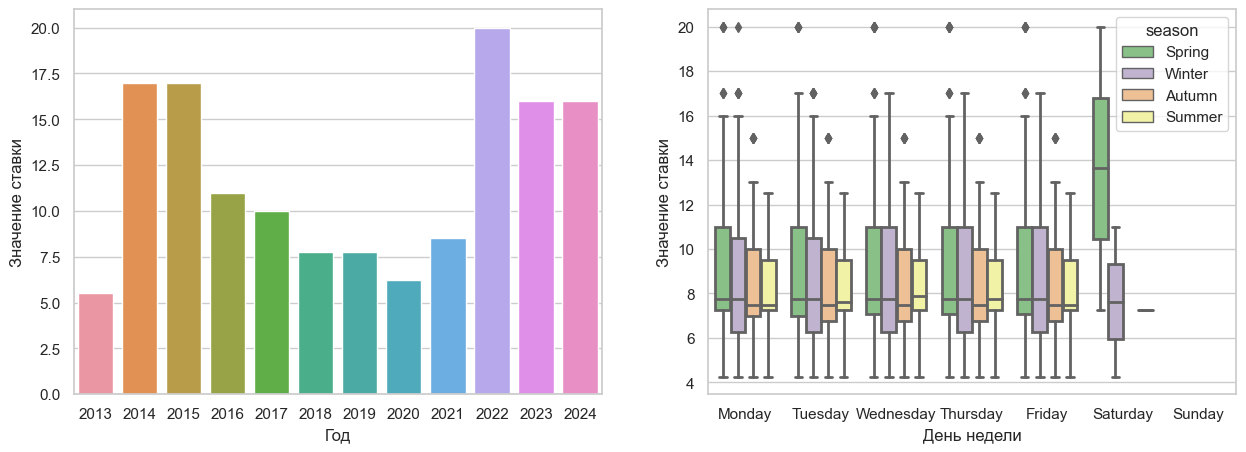

In [542]:
# рисуем графики для анализа
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

year_group = pd.DataFrame(df_features.groupby('year')['key_rate'].max()).reset_index().sort_values('key_rate')

sns.barplot(data=year_group, x='year', y='key_rate', ax=axes[0])
axes[0].set_xlabel('Год')
axes[0].set_ylabel('Значение ставки')

sns.boxplot(data=df_features, x='weekday', y='key_rate', hue='season', ax=axes[1], linewidth=2)
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Значение ставки')

plt.show()



In [543]:
# дропаем редкие субботние ключевые ставки
drop_trash = df_features[(df_features.weekday == 'Saturday')].index
df = df[~df.index.isin(drop_trash)]
df = df.reset_index(drop=True)

In [544]:
# перенаименование названия колонок для prophet
df.columns = ['ds', 'y']

# период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)


In [545]:
# сортируем данные по возрастанию для корректного отображения разделения графика
df = df.sort_values('ds')
df = df.reset_index(drop=True)

In [546]:
# разделение данных на train, test
df_train = df[:-pred_days]
df_test = df[-pred_days:]


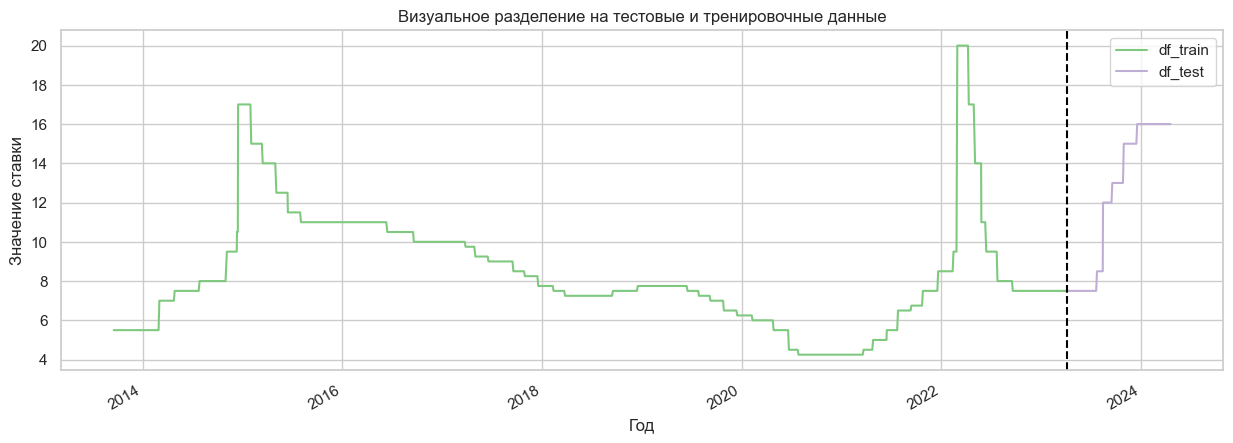

In [547]:
#отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

In [548]:
# обучение модели на train
model = Prophet()
model.fit(df_train)

02:03:09 - cmdstanpy - INFO - Chain [1] start processing
02:03:09 - cmdstanpy - INFO - Chain [1] done processing


In [549]:
future = model.make_future_dataframe(periods=pred_days, freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2635,2023-12-21,11.999862,9.775300,14.462798
2636,2023-12-22,12.013979,9.601690,14.487256
2637,2023-12-23,12.776531,10.382352,15.182051
2638,2023-12-24,12.787499,10.416192,15.222529
2639,2023-12-25,12.010848,9.699242,14.365199


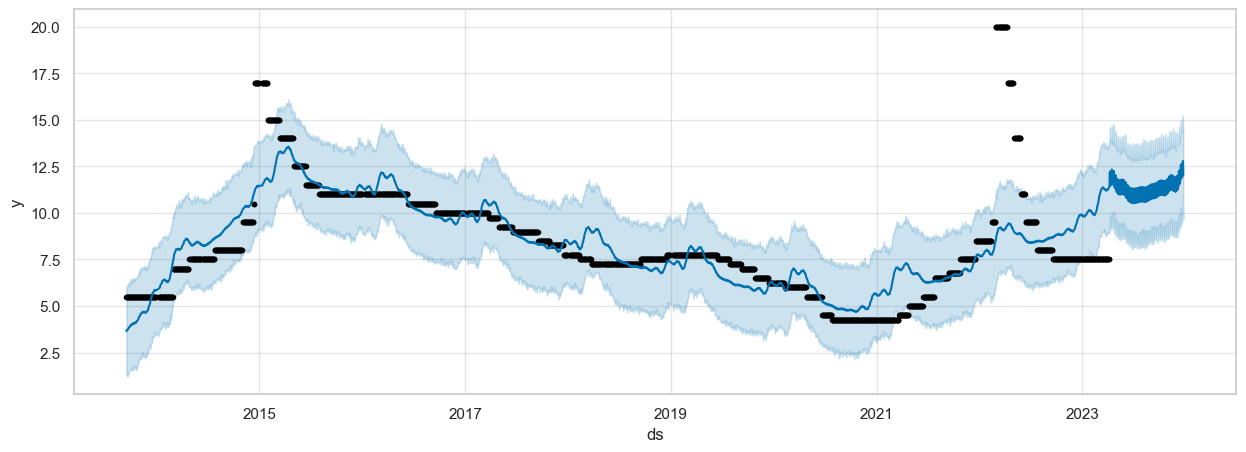

In [550]:
# смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

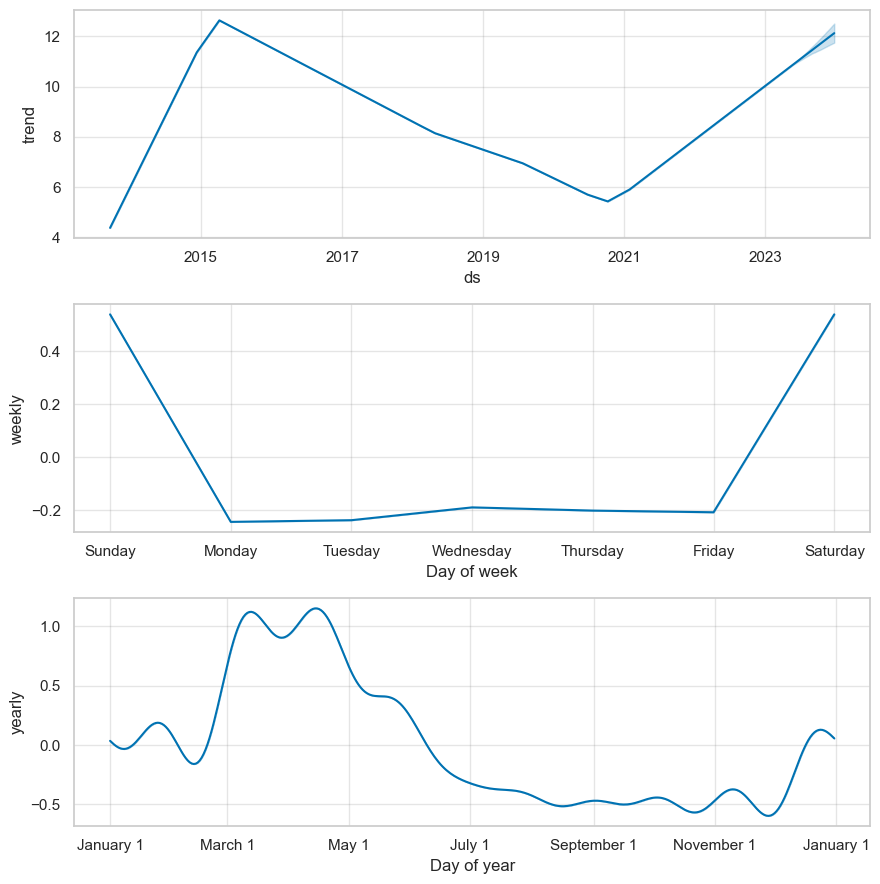

In [551]:
# смотрим тренд, годовые и сезонные признаки
fig = model.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [552]:
df_test_forecast = model.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
259,2024-04-12,13.697464,11.221357,16.039496
260,2024-04-15,13.687687,11.175659,16.187518
261,2024-04-16,13.693689,11.306188,16.244273
262,2024-04-17,13.736862,11.303432,16.128607
263,2024-04-18,13.714772,11.160178,16.209976


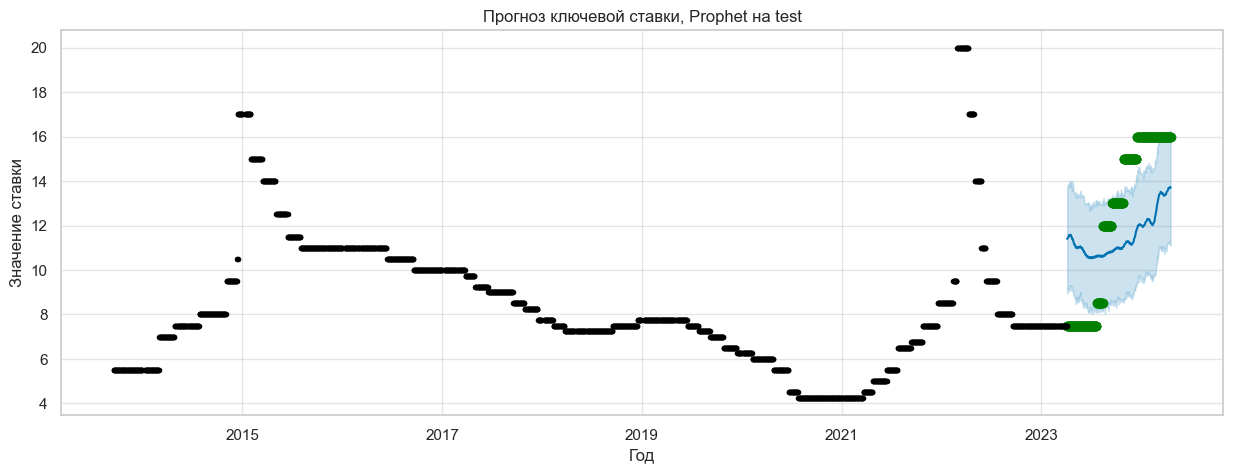

In [553]:
# смотрим совпадение фактического курса с предсказанным курсом prophet обученным на train, проверка модели
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model.predict(df_test)
fig = model.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet на test')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

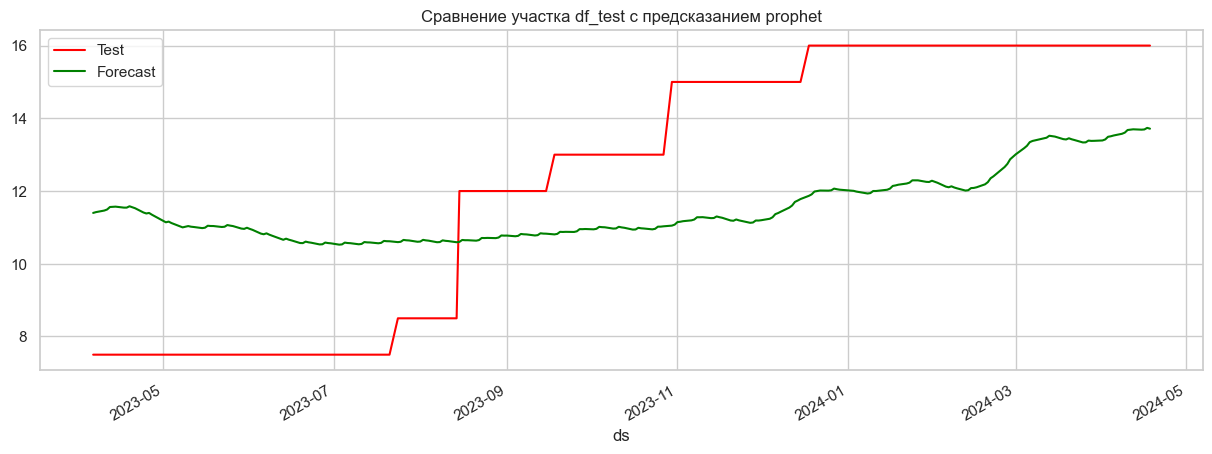

In [554]:
# сравнение участка df_test с предсказанием prophet
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet')
plt.show()

In [555]:
# просмотр метрик модели обученной на train в сравнени с прогнозом
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet,3.000781,0.270794,9.767976,3.125376


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, такие как праздники

In [556]:
# создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [557]:
# тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

02:03:14 - cmdstanpy - INFO - Chain [1] start processing
02:03:14 - cmdstanpy - INFO - Chain [1] done processing


In [558]:
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2635,2023-12-21,11.991081,9.562825,14.341705
2636,2023-12-22,12.020144,9.666883,14.496325
2637,2023-12-23,12.806932,10.291050,15.249177
2638,2023-12-24,12.827791,10.493545,15.243285
2639,2023-12-25,12.042390,9.771294,14.463386


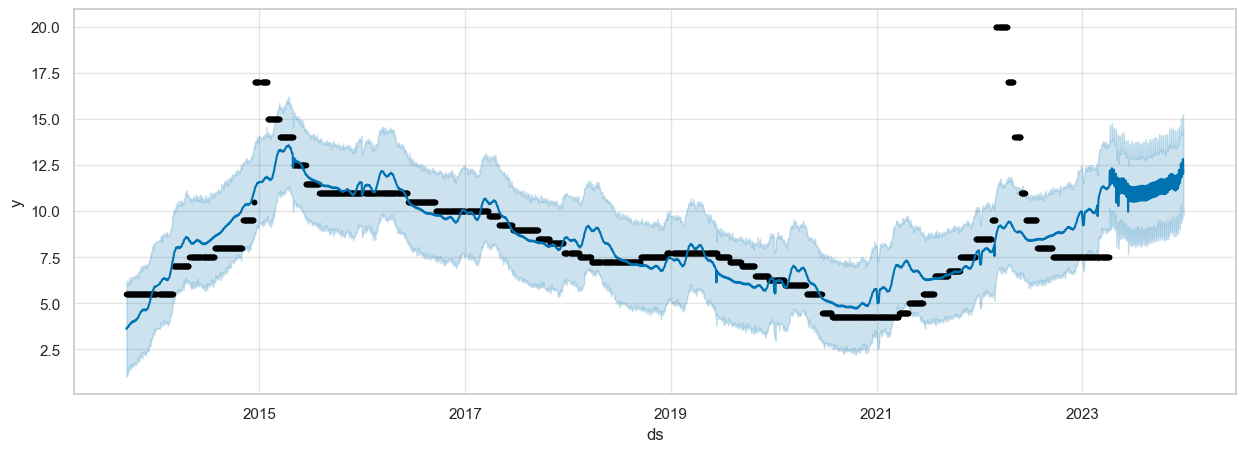

In [559]:
# смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

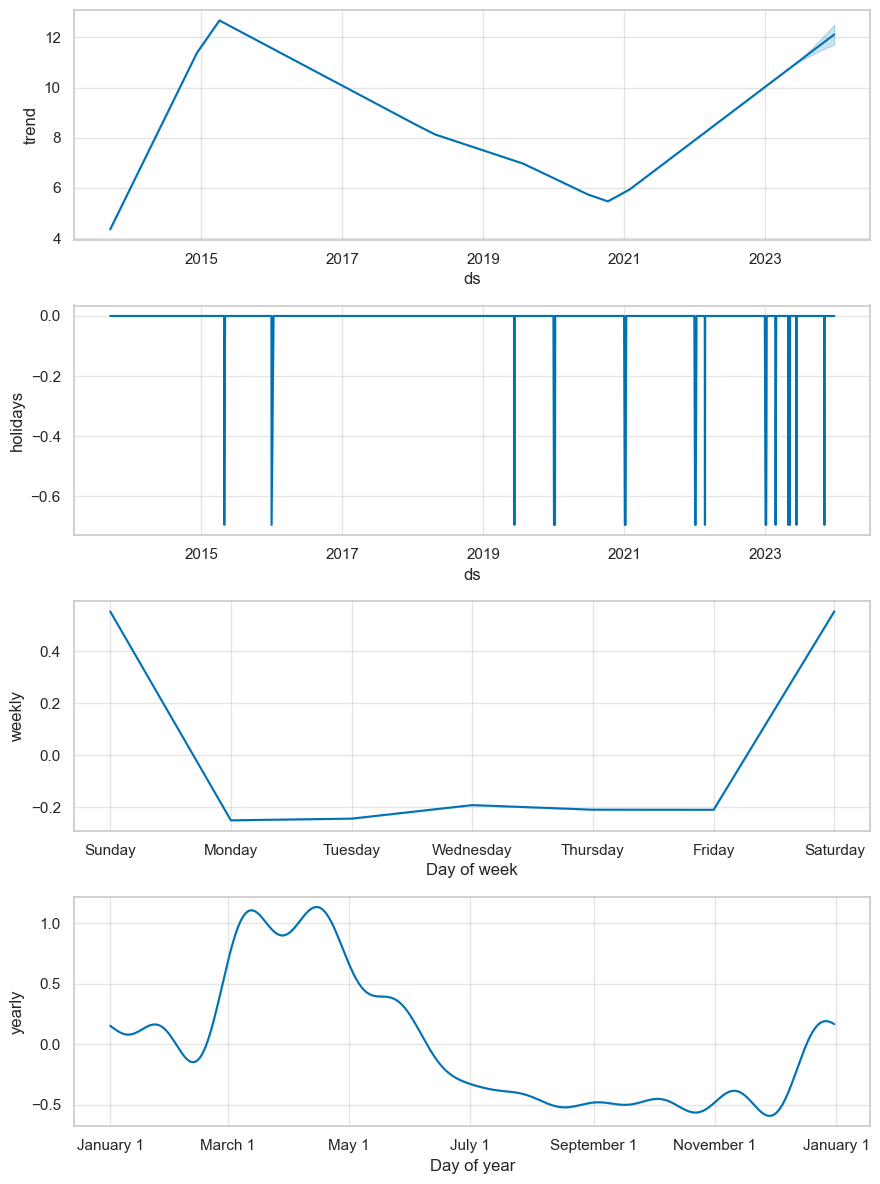

In [560]:
# смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

In [561]:
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
259,2024-04-12,13.657664,11.176744,16.119781
260,2024-04-15,13.647027,11.084596,15.979660
261,2024-04-16,13.654649,11.119120,16.176249
262,2024-04-17,13.703150,11.224407,16.076734
263,2024-04-18,13.677388,10.983723,16.093357


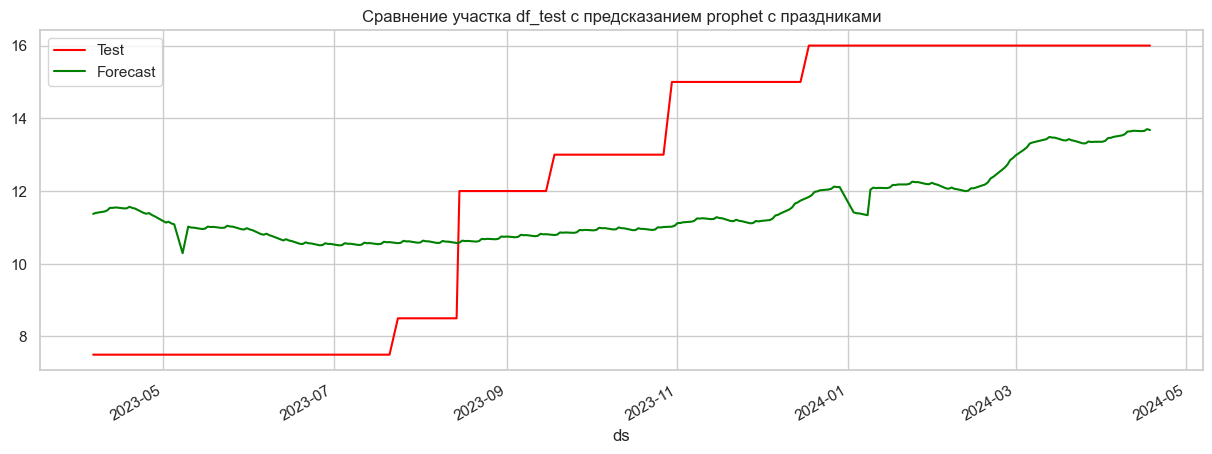

In [562]:
# сравнение участка df_test с предсказанием prophet
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [563]:
# сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet,3.000781,0.270794,9.767976,3.125376
0,Prophet_with_holidays,3.014065,0.271090,9.858037,3.139751


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [564]:
# создание сетки параметров и подсчёт количества вариаций обучения
params_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1, 5, 10], 
    'holidays_prior_scale': [0.01, 0.1, 1, 5, 10],
    'seasonality_mode': ('multiplicative','additive')
}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Количество моделей для обучения по сетке:', cnt)

Количество моделей для обучения по сетке: 200


In [565]:
"""Обучение тестовой модели по сетке параметров"""
# Создаем пустой DataFrame для сохранения метрик
model_grid_metrics = pd.DataFrame()
model_grid_parameters = pd.DataFrame(columns = ['Parameters'])

# Проходимся по сетке гиперпараметров
for p in tqdm(grid):
    #print(p)
#for p in grid:
#    print(p)
    
    # Создаем модель Prophet с текущими гиперпараметрами
    model_grid = Prophet(
        changepoint_prior_scale = p['changepoint_prior_scale'],
        seasonality_prior_scale = p['seasonality_prior_scale'],
        holidays_prior_scale = p['holidays_prior_scale'],
        seasonality_mode = p['seasonality_mode'],
        #changepoint_range = p['changepoint_range'],
        #daily_seasonality = p['daily_seasonality'],
        #weekly_seasonality = p['weekly_seasonality'],
        #yearly_seasonality = p['yearly_seasonality'],
        #holidays=holiday,
    )

    # Добавляем праздники в модель
    #model_grid.add_country_holidays(country_name='RU')

    # Обучаем модель данными
    model_grid.fit(df_train)

    # Создаем фрейм данных для предсказаний
    model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

    # Делаем предсказания
    model_grid_forecast = model_grid.predict(model_grid_future)

    # Вычисляем метрики и добавляем новую строку в df
    model_grid_metrics = pd.concat([model_grid_metrics, get_metrics(y_test=df_test['y'], y_pred=model_grid_forecast['yhat'], name='Prophet_with_grid ')])
    model_grid_parameters = pd.concat([model_grid_parameters, pd.DataFrame({'Parameters': [p]})], ignore_index=True)



  0%|          | 0/200 [00:00<?, ?it/s]02:03:18 - cmdstanpy - INFO - Chain [1] start processing
02:03:18 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/200 [00:00<02:02,  1.62it/s]02:03:19 - cmdstanpy - INFO - Chain [1] start processing
02:03:19 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 2/200 [00:01<01:59,  1.65it/s]02:03:19 - cmdstanpy - INFO - Chain [1] start processing
02:03:20 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 3/200 [00:01<01:58,  1.66it/s]02:03:20 - cmdstanpy - INFO - Chain [1] start processing
02:03:20 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 4/200 [00:02<02:00,  1.63it/s]02:03:21 - cmdstanpy - INFO - Chain [1] start processing
02:03:21 - cmdstanpy - INFO - Chain [1] done processing
  2%|▎         | 5/200 [00:03<01:58,  1.65it/s]02:03:21 - cmdstanpy - INFO - Chain [1] start processing
02:03:22 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 6/200 [00:03<02:01,  1.60it/s]0

In [566]:
# Сброс индексов для будущего объединения с df параметров сетки
model_grid_metrics = model_grid_metrics.reset_index(drop=True)

In [567]:
# Объединение DataFrame по столбцам
metrics_parameters_with_grid = pd.concat([model_grid_metrics, model_grid_parameters], axis=1)
metrics_parameters_with_grid

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,5.310127,0.363976,42.502453,6.519391,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
1,Prophet_with_grid,5.683542,0.394741,47.410688,6.885542,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
2,Prophet_with_grid,5.663180,0.393320,47.078867,6.861404,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
3,Prophet_with_grid,5.642721,0.391727,46.781346,6.839689,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
4,Prophet_with_grid,5.621686,0.390263,46.440240,6.814708,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
...,...,...,...,...,...,...
195,Prophet_with_grid,4.106901,0.330343,19.642862,4.432027,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
196,Prophet_with_grid,4.157265,0.335161,20.071649,4.480139,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
197,Prophet_with_grid,4.181673,0.335521,20.422704,4.519149,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
198,Prophet_with_grid,4.244709,0.336005,21.516077,4.638543,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [568]:
# Сортировка по метрике
metrics_parameters_with_grid = metrics_parameters_with_grid.sort_values(by=['MAE'])
metrics_parameters_with_grid = metrics_parameters_with_grid.reset_index(drop=True)
metrics_parameters_with_grid.head()

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,3.728683,0.318798,15.370058,3.920467,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
1,Prophet_with_grid,3.728683,0.318798,15.370058,3.920467,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
2,Prophet_with_grid,3.728683,0.318798,15.370058,3.920467,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
3,Prophet_with_grid,3.728683,0.318798,15.370058,3.920467,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
4,Prophet_with_grid,3.728683,0.318798,15.370058,3.920467,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."


In [569]:
# Подсвечивание минимальных значений метрик
styled_df = metrics_parameters_with_grid.style.highlight_min(subset=['MAE','MAPE_%','MSE','RMSE'], color='green')
styled_df



,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,3.728683,0.318798,15.370058,3.920467,"{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}"
1,Prophet_with_grid,3.728683,0.318798,15.370058,3.920467,"{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}"
2,Prophet_with_grid,3.728683,0.318798,15.370058,3.920467,"{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}"
3,Prophet_with_grid,3.728683,0.318798,15.370058,3.920467,"{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}"
4,Prophet_with_grid,3.728683,0.318798,15.370058,3.920467,"{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}"
5,Prophet_with_grid,3.735802,0.319092,15.435440,3.928796,"{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}"
6,Prophet_with_grid,3.735802,0.319092,15.435440,3.928796,"{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}"
7,Prophet_with_grid,3.735802,0.319092,15.435440,3.928796,"{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}"
8,Prophet_with_grid,3.735802,0.319092,15.435440,3.928796,"{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}"
9,Prophet_with_grid,3.735802,0.319092,15.435440,3.928796,"{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}"


## Лучшие параметры после обучения по сетке

In [570]:
# Сохранение в переменную лучших параметров после обучения по сетке
best_params = metrics_parameters_with_grid['Parameters'][0]

# Просмотр лучших параметров
best_params


{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 5,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10}

In [571]:
# Обучение модели на лучших параметрах
final_test_model = Prophet(**best_params)
final_test_model.fit(df_train)

02:07:44 - cmdstanpy - INFO - Chain [1] start processing
02:07:45 - cmdstanpy - INFO - Chain [1] done processing


In [572]:
# Вывод всех параметров модели Prophet
print(final_test_model.params)

OrderedDict([('lp__', array([[4452.89]])), ('k', array([[1.5789]])), ('m', array([[0.247933]])), ('delta', array([[ 8.20024e-05,  1.86356e+00,  5.57729e-05, -1.19037e+00,
        -3.16183e+00,  9.09846e-08,  2.93259e-03,  1.43878e-01,
        -3.03417e-07, -1.72351e-07, -3.04890e-08,  2.15291e-07,
        -1.49552e-08,  7.55611e-07,  6.04015e-01,  2.82514e-07,
         1.11583e-07, -2.80705e-08, -9.35593e-01, -6.44771e-03,
         6.28208e-09,  2.86296e-01,  1.80699e+00,  1.15460e+00,
        -1.25252e+00]])), ('sigma_obs', array([[0.088354]])), ('beta', array([[ 0.035305  ,  0.00224677, -0.0016115 , -0.0114316 , -0.00575352,
         0.00464375, -0.00088647,  0.00523663,  0.00117208,  0.00438342,
         0.00200385,  0.00176069,  0.00062534,  0.00115759,  0.00026238,
        -0.00273418, -0.00472144, -0.00256349, -0.00371439,  0.00032911,
         0.00633809, -0.00405891, -0.00593035, -0.00104682,  0.00080893,
         0.00143414]])), ('trend', array([[0.247933, 0.248386, 0.248839, 

In [573]:
# Прогнозировние после обучния на луших параметрах
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2635,2023-12-21,11.632068,9.055976,14.254400
2636,2023-12-22,11.646201,9.164979,14.262835
2637,2023-12-23,11.962011,9.384463,14.425649
2638,2023-12-24,11.974686,9.609423,14.604523
2639,2023-12-25,11.655925,9.291067,14.314481


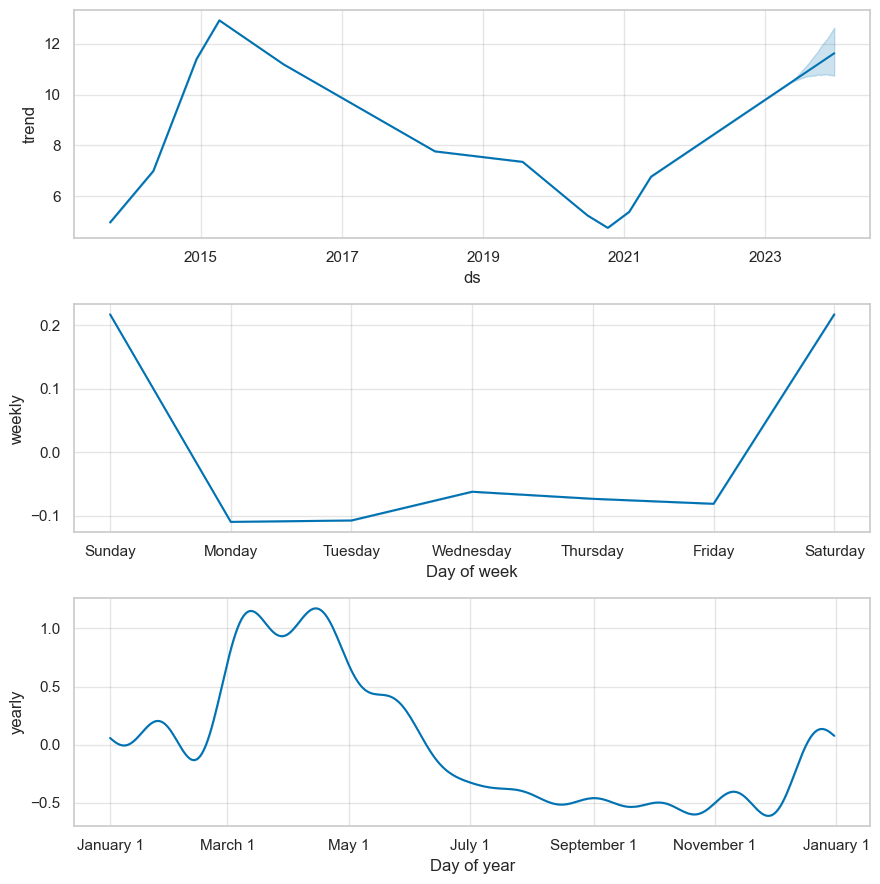

In [574]:
# Просмотр компонентов
fig = final_test_model.plot_components(forecast)

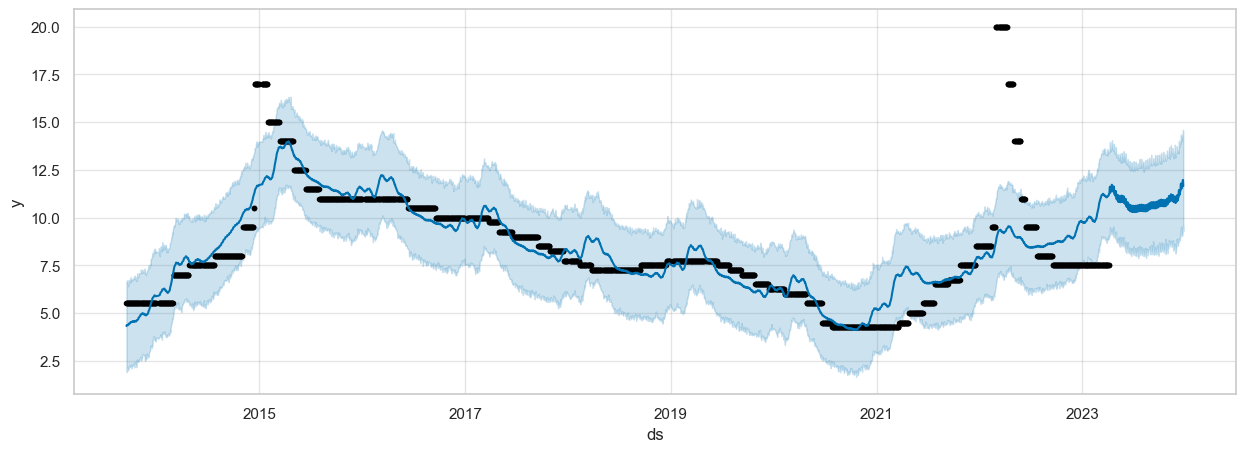

In [575]:
# Смотрим график прогноза и фактического df_dest после обучния на лучших параметрах
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

In [576]:
# Просмотр df данных после предсказания на лучших параметрах
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
259,2024-04-12,13.272099,10.556091,16.068592
260,2024-04-15,13.267151,10.435149,16.087017
261,2024-04-16,13.268101,10.556629,15.809899
262,2024-04-17,13.307374,10.442828,16.120343
263,2024-04-18,13.285493,10.309726,15.818840


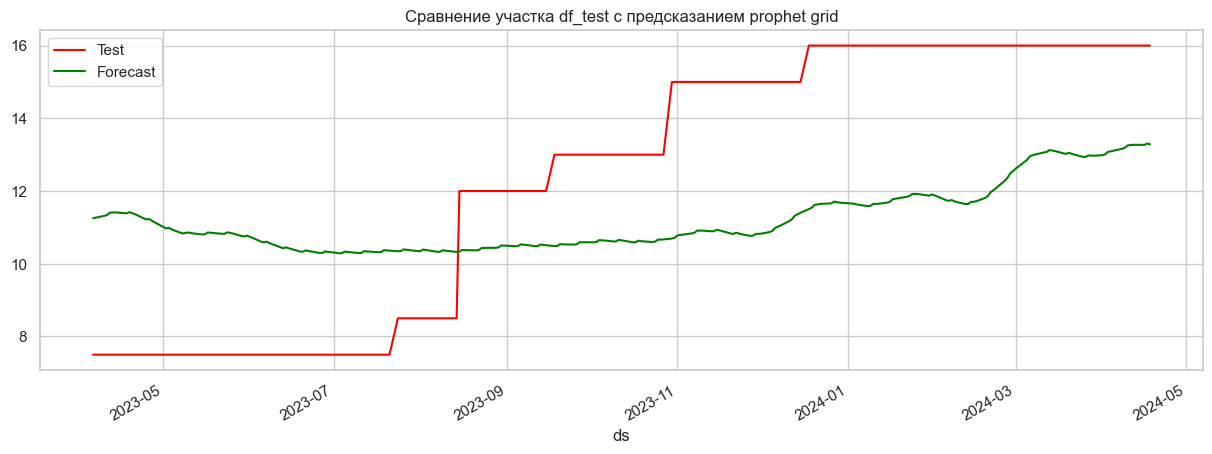

In [577]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [578]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_with_grid')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet,3.000781,0.270794,9.767976,3.125376
0,Prophet_with_holidays,3.014065,0.271090,9.858037,3.139751
0,Prophet_with_grid,3.165121,0.277416,10.813903,3.288450


In [579]:
# Сохранение DataFrame df в файл data/df.csv
df.to_csv('../data/df.csv', index=False)

# Сохранение DataFrame df_train в файл data/df_train.csv
df_train.to_csv('../data/df_train.csv', index=False)

# Сохранение DataFrame df_test в файл data/df_test.csv
df_test.to_csv('../data/df_test.csv', index=False)


In [580]:
# Сохранение модели в JSON файл
with open('../backend/final_test_model.json', 'w') as fout:
    fout.write(model_to_json(final_test_model))

In [581]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(final_test_model, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()


  0%|          | 0/14 [00:00<?, ?it/s]

02:07:49 - cmdstanpy - INFO - Chain [1] start processing
02:07:49 - cmdstanpy - INFO - Chain [1] done processing
02:07:50 - cmdstanpy - INFO - Chain [1] start processing
02:07:50 - cmdstanpy - INFO - Chain [1] done processing
02:07:50 - cmdstanpy - INFO - Chain [1] start processing
02:07:51 - cmdstanpy - INFO - Chain [1] done processing
02:07:51 - cmdstanpy - INFO - Chain [1] start processing
02:07:52 - cmdstanpy - INFO - Chain [1] done processing
02:07:52 - cmdstanpy - INFO - Chain [1] start processing
02:07:53 - cmdstanpy - INFO - Chain [1] done processing
02:07:53 - cmdstanpy - INFO - Chain [1] start processing
02:07:54 - cmdstanpy - INFO - Chain [1] done processing
02:07:54 - cmdstanpy - INFO - Chain [1] start processing
02:07:55 - cmdstanpy - INFO - Chain [1] done processing
02:07:55 - cmdstanpy - INFO - Chain [1] start processing
02:07:56 - cmdstanpy - INFO - Chain [1] done processing
02:07:56 - cmdstanpy - INFO - Chain [1] start processing
02:07:57 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-11-09,11.700836,11.034633,12.344699,11.0,2015-11-08
1,2015-11-10,11.779917,11.097832,12.481694,11.0,2015-11-08
2,2015-11-11,11.829573,11.156901,12.542457,11.0,2015-11-08
3,2015-11-12,11.831709,11.121547,12.535881,11.0,2015-11-08
4,2015-11-13,11.843715,11.173222,12.517958,11.0,2015-11-08


In [582]:
cutoffs = pd.to_datetime(['2015-11-03', '2016-05-03', '2016-11-03'])
df_cv2 = cross_validation(final_test_model, cutoffs=cutoffs, horizon='365 days')
df_cv2.head()

  0%|          | 0/3 [00:00<?, ?it/s]

02:08:05 - cmdstanpy - INFO - Chain [1] start processing
02:08:05 - cmdstanpy - INFO - Chain [1] done processing
02:08:06 - cmdstanpy - INFO - Chain [1] start processing
02:08:06 - cmdstanpy - INFO - Chain [1] done processing
02:08:06 - cmdstanpy - INFO - Chain [1] start processing
02:08:07 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-11-05,11.608869,10.956875,12.324545,11.0,2015-11-03
1,2015-11-06,11.677307,10.959327,12.372834,11.0,2015-11-03
2,2015-11-09,11.842797,11.114990,12.563601,11.0,2015-11-03
3,2015-11-10,11.923274,11.201090,12.634054,11.0,2015-11-03
4,2015-11-11,11.975358,11.279537,12.653494,11.0,2015-11-03


In [583]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,38 days,3.173619,1.781465,0.985857,0.109621,0.060046,0.121804,0.645115
1,39 days,2.984450,1.727556,0.975733,0.110532,0.061304,0.122593,0.645594
2,40 days,2.787133,1.669471,0.964864,0.111348,0.060046,0.123234,0.646552
3,41 days,2.759261,1.661102,0.973014,0.112876,0.062548,0.125025,0.644636
4,42 days,2.800181,1.673374,0.986870,0.114301,0.063196,0.126645,0.644636


In [584]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv2)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,0.372432,0.610272,0.500356,0.046418,0.033818,0.045499,0.743243
1,37 days,0.418477,0.646898,0.520692,0.048266,0.034439,0.047188,0.729730
2,38 days,0.474509,0.688846,0.542882,0.050284,0.034506,0.049010,0.716216
3,39 days,0.474094,0.688545,0.541220,0.050118,0.034506,0.048846,0.716216
4,40 days,0.473934,0.688429,0.540832,0.050079,0.034506,0.048808,0.716216


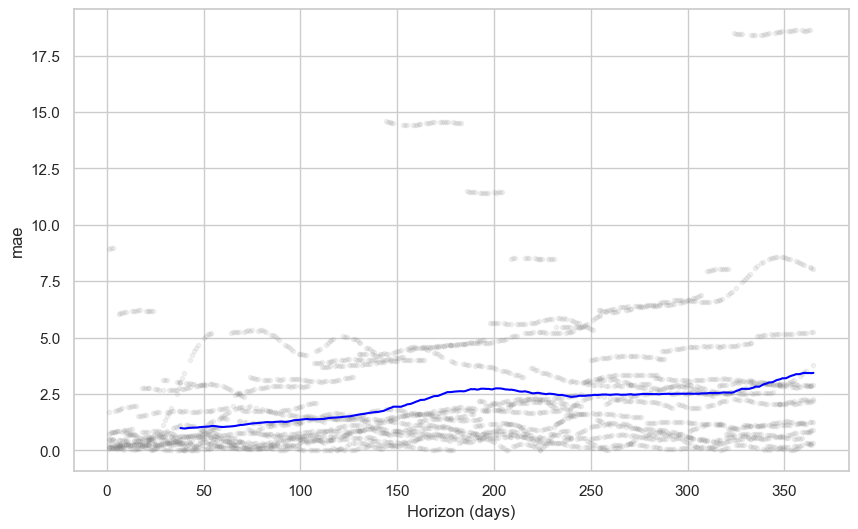

In [585]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')

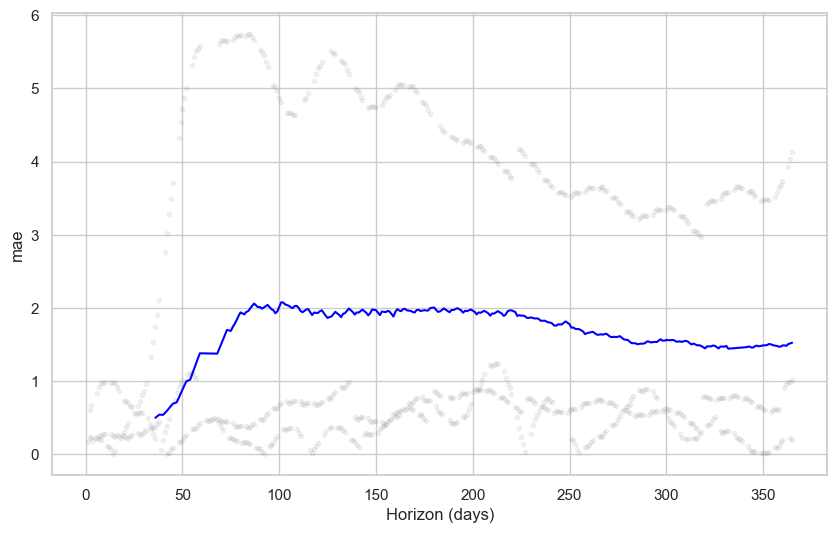

In [586]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv2, metric='mae')

In [590]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1, 5, 10], 
    'holidays_prior_scale': [0.01, 0.1, 1, 5, 10],
    'seasonality_mode': ('multiplicative','additive'),
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mae = []  # Store the MAEs for each params here
mape = []  # Store the MAPEs for each params here
mse = []  # Store the MSEs for each params here
rmse = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
#for params in all_params:
for params in tqdm(all_params):
    m = Prophet(**params).fit(df_train)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mae.append(df_p['mae'].values[0])
    mape.append(df_p['mape'].values[0])
    mse.append(df_p['mse'].values[0])
    rmse.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['MAE'] = mae
tuning_results['MAPE'] = mape
tuning_results['MSE'] = mse
tuning_results['RMSE'] = rmse
print(tuning_results)

  0%|          | 0/200 [00:00<?, ?it/s]02:09:16 - cmdstanpy - INFO - Chain [1] start processing
02:09:16 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/200 [00:03<12:54,  3.89s/it]02:09:20 - cmdstanpy - INFO - Chain [1] start processing
02:09:20 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 2/200 [00:08<13:16,  4.02s/it]02:09:24 - cmdstanpy - INFO - Chain [1] start processing
02:09:24 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 3/200 [00:11<12:58,  3.95s/it]02:09:28 - cmdstanpy - INFO - Chain [1] start processing
02:09:28 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 4/200 [00:16<13:20,  4.08s/it]02:09:33 - cmdstanpy - INFO - Chain [1] start processing
02:09:33 - cmdstanpy - INFO - Chain [1] done processing
  2%|▎         | 5/200 [00:21<14:20,  4.41s/it]02:09:37 - cmdstanpy - INFO - Chain [1] start processing
02:09:38 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 6/200 [00:26<15:14,  4.71s/it]0

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale   
0                      0.001                     0.01                  0.01  \
1                      0.001                     0.01                  0.01   
2                      0.001                     0.01                  0.10   
3                      0.001                     0.01                  0.10   
4                      0.001                     0.01                  1.00   
..                       ...                      ...                   ...   
195                    0.500                    10.00                  1.00   
196                    0.500                    10.00                  5.00   
197                    0.500                    10.00                  5.00   
198                    0.500                    10.00                 10.00   
199                    0.500                    10.00                 10.00   

    seasonality_mode       MAE      MAPE       MSE 

In [598]:
best_params_grid_cv = all_params[np.argmin(mse)]
print(best_params_grid_cv)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [592]:
tuning_results.sort_values(by=['MAE'])

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,MAE,MAPE,MSE,RMSE
153,0.500,0.01,0.10,additive,0.300255,0.028102,0.126335,0.355437
155,0.500,0.01,1.00,additive,0.300255,0.028102,0.126335,0.355437
157,0.500,0.01,5.00,additive,0.300255,0.028102,0.126335,0.355437
159,0.500,0.01,10.00,additive,0.300255,0.028102,0.126335,0.355437
151,0.500,0.01,0.01,additive,0.300255,0.028102,0.126335,0.355437
...,...,...,...,...,...,...,...,...
20,0.001,1.00,0.01,multiplicative,3.117163,0.290674,10.139861,3.184315
24,0.001,1.00,1.00,multiplicative,3.117163,0.290674,10.139861,3.184315
22,0.001,1.00,0.10,multiplicative,3.117163,0.290674,10.139861,3.184315
28,0.001,1.00,10.00,multiplicative,3.117163,0.290674,10.139861,3.184315
